In this notebook we explore how to do linear regression using Bayesian inference and a Metropolis MCMC sampler.

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec 

import metropolis

np.random.seed(123) # For reproducing random results

Polynomial function of the form $y = a_0 + a_1 x + \epsilon$ where $\epsilon$ is some noise model.

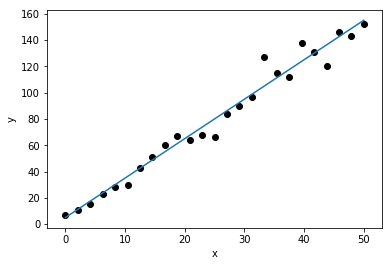

In [2]:
a = [5, 3]
x = np.linspace(0, 50, num=25)

line = lambda a, x: a[0] + a[1]*x
y_true = line(a, x)
y_obs = np.random.poisson(y_true)

plt.plot(x, y_true);
plt.scatter(x, y_obs, c='k');
plt.xlabel('x'); plt.ylabel('y');

Now set up the prior, first guess of the prior, likelihood, number of iterations, and the target function (product of the prior and likelihoods).

In [10]:
def gaus_likelihood(f, p, x, y):
    """ 
    Gaussian likelihood. 
    ARUMENTS:
    f : the function that transforms (p, x) -> y_model 
        for a choice of prior variables.
    p : parameters for the model.
    x : independent variable.
    y : observed data.    
    """
    y_model = f(p, x)
    C = (np.std(y)*np.sqrt(2*np.pi))
    exp_args = sum([(y_i - y_model_i)**2 
                for (y_i, y_model_i) in zip(y, y_model)])
    return np.exp(-0.5*exp_args/np.std(y_model)**2)/C

In [11]:
prior = [ 
        scipy.stats.norm(loc=20, scale=30),
        scipy.stats.norm(loc=0, scale=30) 
        ]
# Initial guess for the prior variables.
start = [prior_i.rvs() for prior_i in prior]
# Number of iterations
n_iter = 20000
n_burn = n_iter//10

def target(p):
    """ Target function which is the product of the liekihood and prior """
    l = gaus_likelihood(line, p, x, y_obs)
    prior_prob = np.prod([prior_i.pdf(p_i) for prior_i, p_i in zip(prior, p)])
    return l*prior_prob

def proposal(p, proposal_jump=[1, 1]):
    """ 
    Generate a new proposal, or "guess" for the MCMC to try next. 
    The new proposed value is picked from a Normal, centered on 
    the old value given by p. The proposal_jump array specifies 
    the standard deviation of the possible jumps from the prior
    parameter value.
    """
    new_vals = np.array([scipy.stats.norm(loc=p_i, scale=jump_i).rvs() 
                    for p_i, jump_i in zip(p, proposal_jump)])    
    return new_vals

Now run the MCMC sampler.

In [12]:
trace = metropolis.metropolis(start, target, proposal, n_iter, nburn=n_burn)

100% (20000 of 20000) |##################| Elapsed Time: 0:01:17 Time:  0:01:17


Now visualize the posterior distributions with the true values shown with black vertical line.

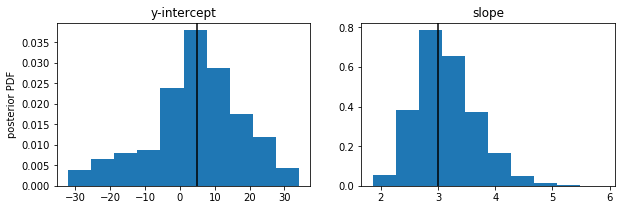

In [13]:
_, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].hist(trace[:, 0], density=True); ax[0].axvline(a[0], c='k'); ax[0].set_title('y-intercept');
ax[1].hist(trace[:, 1], density=True); ax[1].axvline(a[1], c='k'); ax[1].set_title('slope')
ax[0].set_ylabel('posterior PDF');

Now calculate the statistics on the trace plots i.e. 2.5, 50 (median), and 97.5 percentiles. Put into a DataFrame to make a pritty table.

In [14]:
percentiles = np.nan*np.zeros((len(a), 4))

for i, trace_i in enumerate(trace.T):
    percentiles[i, :-1] = np.percentile(trace_i, [2.5, 50, 97.5])
    percentiles[i, -1] = a[i]
df = pd.DataFrame(data=percentiles, columns=['2.5%', '50%', '97.5%', 'true'], 
                  index=[f'a{i}' for i in range(len(a))])

In [15]:
df

,2.5%,50%,97.5%,true
a0,-25.452426,5.110113,27.822505,5.0
a1,2.271219,3.072144,4.289947,3.0


Now lets make an instructional animation.

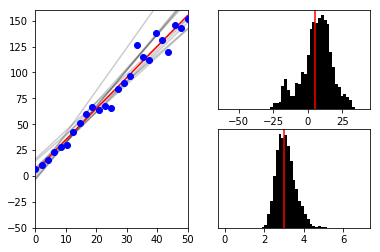

In [20]:
fig = plt.figure()
gs = matplotlib.gridspec.GridSpec(2, 2)
ax = plt.subplot(gs[:, 0], xlim=(0, 50), ylim=(-50, 160))
bx = plt.subplot(gs[0, 1], xlim=(-60, 40))
cx = plt.subplot(gs[1, 1], xlim=(0, 6))
bx.get_yaxis().set_visible(False)
cx.get_yaxis().set_visible(False)

ax.plot(x, line(a, x), c='r', zorder=10000)
ax.scatter(x, y_obs, c='b', zorder=10001)
animate_line, = ax.plot([], [], lw=3)

skip_frames = 100 # How many trace values to skip for each frame.
plot_memory = 10  # How many last 
frames = 100
intercept_bins = np.linspace(-60, 40)
slope_bins = np.linspace(0, 7)

def init():
    animate_line.set_data([], [])
    return animate_line,

def animate(i):
    #     frame_counter = ax.text(1, 1, i, )
    # delete all but plot_memory number of lines.
    if len(ax.lines) > plot_memory + 1:
        ax.lines.pop(2) # Remove the 1st element since the 0th is the true line.
        # Now there the number of lines should be of plot_memory.
    # Plot another line
    ax.plot(x, line(trace[i*skip_frames, :], x), c='k', alpha=0.2)
    bx.clear(); cx.clear()
    bx.axvline(a[0], c='r')
    cx.axvline(a[1], c='r')
    bx.hist(trace[:i*skip_frames, 0], color='k', bins=intercept_bins)
    cx.hist(trace[:i*skip_frames, 1], color='k', bins=slope_bins)
    
    return animate_line,

anim = FuncAnimation(fig, animate, init_func=init,
                    frames=frames, 
                    interval=100, blit=True)
anim.save('linear_regression_from_scratch.gif', writer='imagemagick')